# Introduction to Classifying Satellite Images with TensorFlow

In this tutorial, we'll explore how to build a convolutional neural network (CNN) with TensorFlow to classify the land use or land cover from satellite images. The satellite images are from the EuroSAT dataset and they are labeled after the land use or land cover. There are 10 different classes of land use or land cover for this task: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake. For more info about the dataset check out: https://github.com/phelber/EuroSAT. 

We'll go through loading and preprocessing the dataset, building and training a CNN model, and evaluating its performance through accuracy metrics and a confusion matrix. Additionally, we'll visualize misclassified images to understand where our model might be making mistakes.

# Load packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# THIS MIGHT BE NEEDED IF THE KERNEL SHUTS DOWN DURING THE TUTORIAL (THINK THIS IS ONLY WINDOWS RELATED)
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Load and preprocess the data
This cell loads and preprocesses the EuroSAT dataset, dividing it into 70% training, 15% validation, and 15% test sets. It uses inherent functions in TensorFlow to shuffle, load the 64x64 images, and batch the dataset.

In [3]:
def load_and_preprocess_data(batch_size=32):
    # Load the EuroSAT dataset
    (ds, ds_info) = tfds.load(
        'eurosat/rgb',
        split='train',
        as_supervised=True,
        with_info=True,
        shuffle_files=True
    )

    # Splitting the dataset
    train_size = int(0.7 * ds_info.splits['train'].num_examples)
    val_size = int(0.15 * ds_info.splits['train'].num_examples)
    test_size = int(0.15 * ds_info.splits['train'].num_examples)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)

    # Batching the dataset
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) 
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) 
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) 

    # Normalize the datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    return train_ds, val_ds, test_ds, ds_info.features['label'].names

train_dataset, val_dataset, test_dataset, class_names = load_and_preprocess_data(batch_size=32)


## Normalize the images so the pixel values ranges between 0 and 1

# Get to know the data

## Visualize some images from the training dataset
Run the cell below to see different images from the EuroSAT dataset (run it again to see new images)

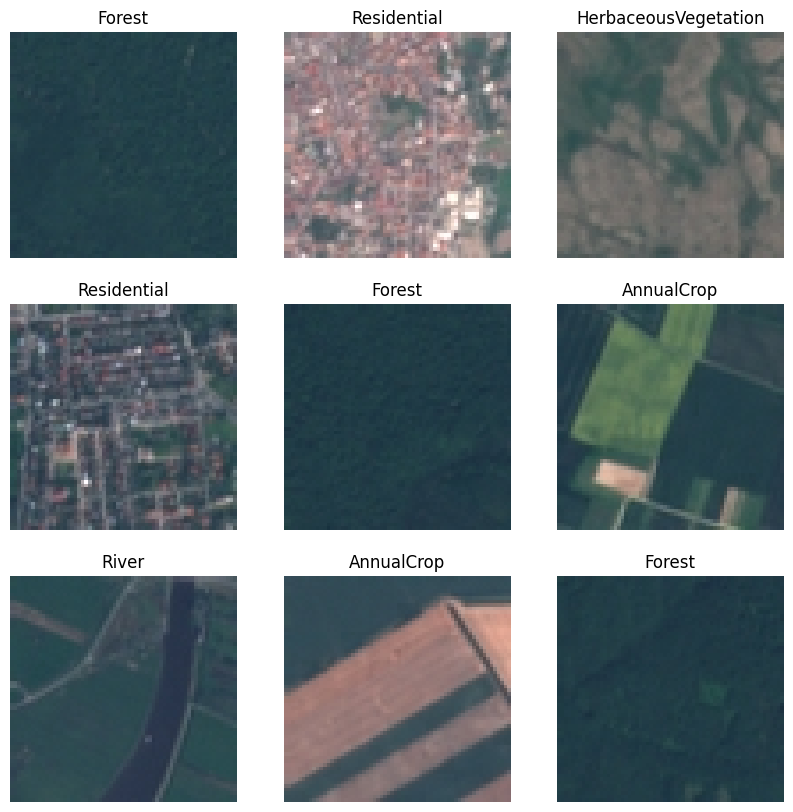

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i]
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Build the CNN Model
In this section, we build the CNN model with layers designed for feature extraction and classification. 
* Input Layer: It specifies the input shape as 64x64 pixels with 3 channels, suitable for RGB images from the EuroSAT dataset.

* Convolutional Layers: There are three convolutional layers in this model, each followed by a max pooling layer. The convolutional layers have 32, 64, and 128 filters, respectively, with a kernel size of 3x3 and ReLU (Rectified Linear Unit) activation. These layers are responsible for extracting features from the input images.

* Max Pooling Layers: Each max pooling layer uses a pool size of 2x2, reducing the spatial dimensions of the feature maps by half. This operation helps to decrease the computational load, memory usage, and also helps in making the model more robust to slight variations in the input data.

* Flatten Layer: After the final max pooling step, a flatten layer is used to convert the 3D feature maps into a 1D feature vector. This is necessary as the input to the subsequent dense layers.

* Dense Layers: Following the flatten layer, there is a dense layer with 256 neurons and ReLU activation, which serves as a fully connected layer that learns the non-linear combinations of the high-level features extracted by the convolutional layers. After this, a dropout layer with a rate of 0.5 is used to reduce overfitting by randomly setting a fraction of the input units to 0 during training.

* Output Layer: The final layer is a dense layer with 10 neurons, corresponding to the 10 classes in the EuroSAT dataset, and uses a softmax activation function. This layer outputs the probability distribution over the 10 classes, where the neuron with the highest probability indicates the model's prediction.
* We compile it with the Adam optimizer and cross-entropy loss function.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model

In [7]:
history = model.fit(train_dataset, epochs=15, validation_data=(val_dataset))

Epoch 1/15
591/591 [==============================] - 534s 902ms/step - loss: 1.3707 - accuracy: 0.4771 - val_loss: 1.0583 - val_accuracy: 0.5936
Epoch 2/15
591/591 [==============================] - 373s 631ms/step - loss: 0.9942 - accuracy: 0.6457 - val_loss: 0.7535 - val_accuracy: 0.7227
Epoch 3/15
591/591 [==============================] - 390s 659ms/step - loss: 0.8283 - accuracy: 0.7037 - val_loss: 0.6300 - val_accuracy: 0.7810
Epoch 4/15
591/591 [==============================] - 47s 79ms/step - loss: 0.7037 - accuracy: 0.7513 - val_loss: 0.6018 - val_accuracy: 0.7862
Epoch 5/15
591/591 [==============================] - 53s 89ms/step - loss: 0.6330 - accuracy: 0.7790 - val_loss: 0.5257 - val_accuracy: 0.8148
Epoch 6/15
591/591 [==============================] - 53s 89ms/step - loss: 0.5635 - accuracy: 0.8016 - val_loss: 0.5250 - val_accuracy: 0.8141
Epoch 7/15
591/591 [==============================] - 48s 82ms/step - loss: 0.5226 - accuracy: 0.8185 - val_loss: 0.4717 - val_acc

If training takes too long on your computer (>20min), you can load a base CNN model that is already trained by running the cell below. Unfortunatly you won't be able to plot the training history when preloading a model.

In [ ]:
# base_model_file = 'models/base_cnn_model'
# model = tf.keras.models.load_model(base_model_file)

# Evaluate model performance
Post-training, we plot the accuracy and loss for both training and validation phases over epochs, and evaluate the model's performance on the test dataset.

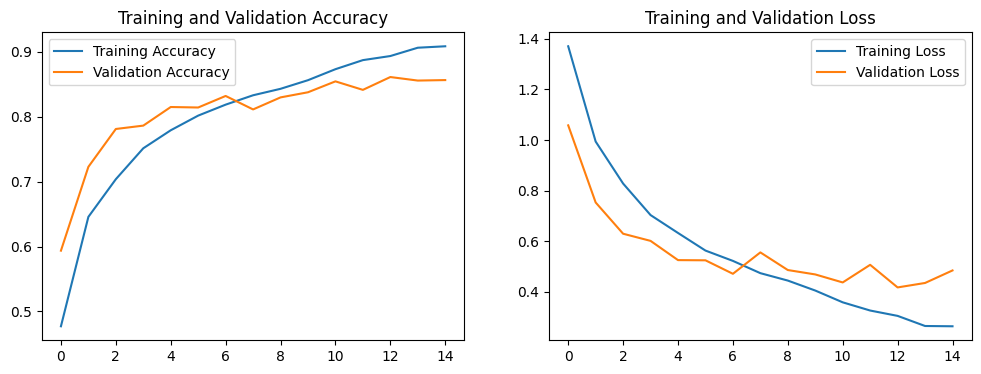

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [9]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Accuracy on the test dataset: {test_acc*100:.2f}%')

127/127 [==============================] - 2s 18ms/step - loss: 0.4857 - accuracy: 0.8467
Accuracy on the test dataset: 84.67%


This reasonably "vanilla" CNN reaches a accuracy of around 86+-2% , i.e. if you provide this model with unseen images, 87 images of 100 are classified correctly. The state-of-the-art models are reaching above 99% accuracy on this dataset (https://paperswithcode.com/sota/image-classification-on-eurosat).

## Analyze misclassifications with a confusion matrix
In the following cells we generate a confusion matrix to analyze the model's predictions across different classes, helping identify where it gets confused.

In [10]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)
# This evalutates the class probabilities and classifies the predictions to class with highest probability
predicted_classes = np.argmax(predictions, axis=1)
# Get the true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

print('The predicted class for the 10 first instances in the test dataset: \n' + str(predicted_classes[:10]))
print('The actual class for the 10 first instances in the test dataset: \n' + str(true_labels[:10]))

127/127 [==============================] - 3s 20ms/step
The predicted class for the 10 first instances in the test dataset: 
[4 7 7 6 9 2 7 5 7 4]
The actual class for the 10 first instances in the test dataset: 
[4 7 7 6 9 2 7 5 3 4]


### Create a confusion matrix plot
A confusion matrix plot visualizes the accuracy of a classification model. Here's how to interpret it:
* The x-axis shows predicted classes; the y-axis shows actual classes.
* In the diagonal cells we see the counts of correct predictions. High numbers here indicate better model performance.
* In the off-diagonal cells we see the counts of misclassifications. Cells away from the diagonal where higher numbers suggest areas where the model is confused.
* Color intensity is often used to highlight frequencies. Darker shades usually mean higher counts, making it easier to spot patterns or frequent misclassifications.

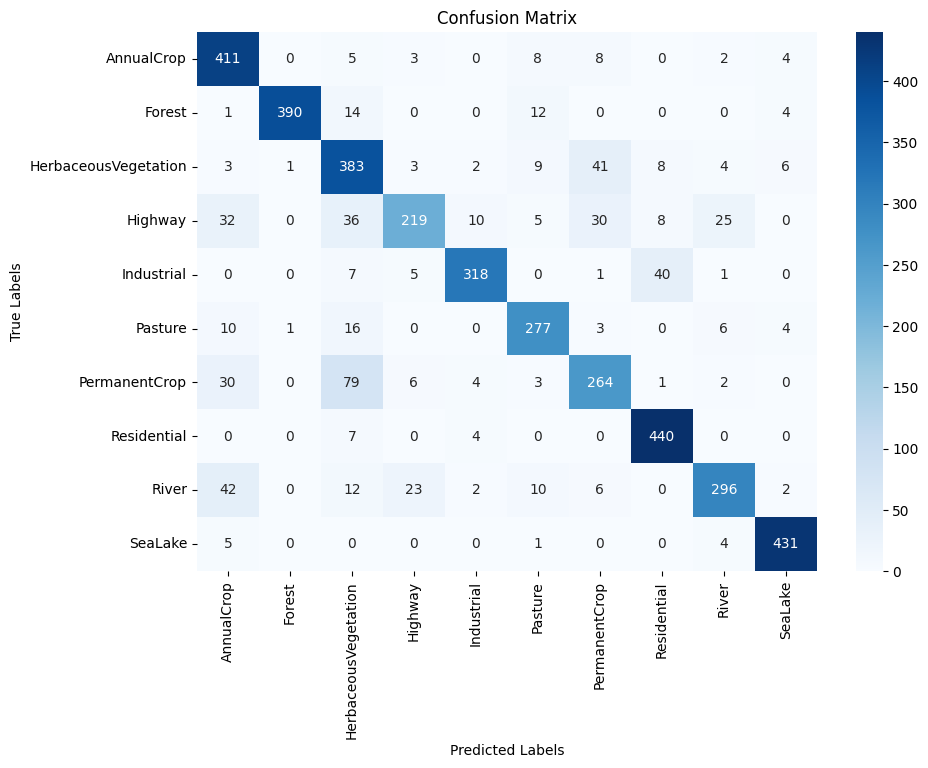

In [11]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In this confusion matrix plot, we can see that PermanentCrop images usually gets misclassified as HerbaceousVegetation or Highways, as well as River images get misclassified as Highways. This is a common pattern with this dataset, but might look slightly different for your model.

# Visualize misclassified images
Finally, we extract misclassified images and plot a selection of them. This step is crucial for understanding the model's mistakes.

In [12]:
def extract_misclassified_images(dataset, misclassified_indices):
    # Function to extract the misclassified images and their labels
    images_mc = []
    true_labels_mc = []
    predicted_labels_mc = []

    for i, (images, labels) in enumerate(dataset.unbatch()):
        if i in misclassified_indices:
            images_mc.append(images.numpy())
            true_labels_mc.append(labels.numpy())
            predicted_labels_mc.append(predicted_classes[i])
       
    return images_mc, true_labels_mc, predicted_labels_mc

# Get the indicies where the model missclassified
misclassified_indices = np.where(predicted_classes != true_labels)[0]

images_mc, true_labels_mc, pred_labels_mc = extract_misclassified_images(test_dataset, misclassified_indices)

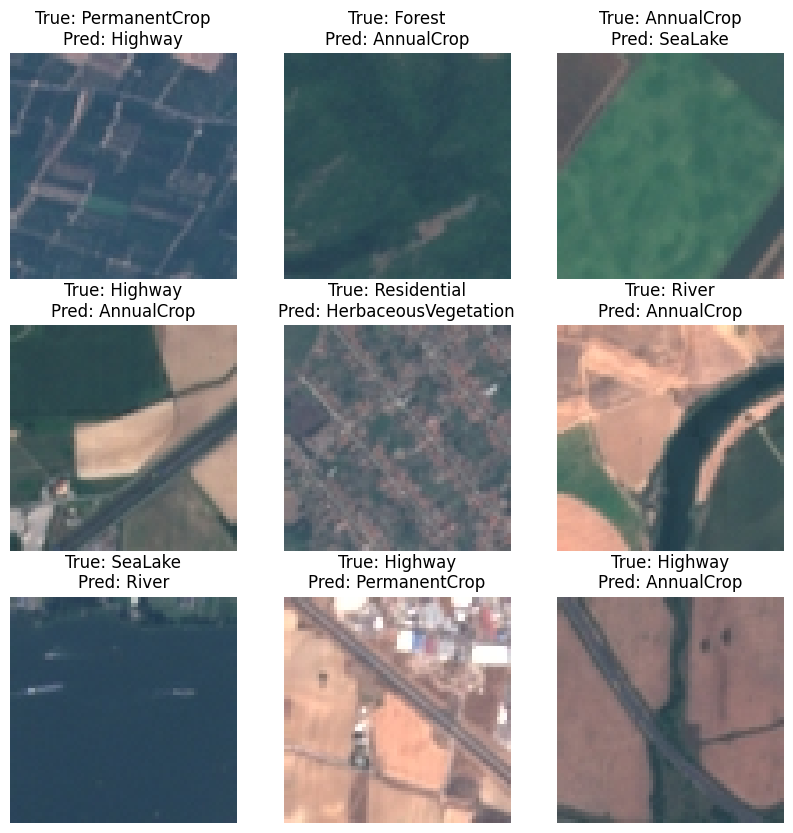

In [13]:
def plot_misclassified_images(images, true_labels, predicted_labels, class_names): 
    plt.figure(figsize=(10, 10))
    num_images = 9
    for i, img in enumerate(np.random.choice(len(images), size=num_images, replace=False)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[img])
        plt.title(f"True: {class_names[true_labels[img]]}\nPred: {class_names[predicted_labels[img]]}")
        plt.axis("off")
    plt.show()

plot_misclassified_images(images_mc, true_labels_mc, pred_labels_mc, class_names)

Examine these images and see if you could understand why the model might have classified the images as it did.

# Summary

In this tutorial, we explored how to classify satellite images using TensorFlow and the EuroSAT dataset. We started by loading and preprocessing the dataset to make it suitable for model training, which included shuffling, batching, and normalizing the images.

We then constructed a Convolutional Neural Network (CNN) tailored for image classification. The model consisted of several convolutional layers to extract features from the images, pooling layers to reduce dimensionality, and dense layers for classification. To prevent overfitting, a dropout layer was also included.

After building the model, we trained it on the training dataset while monitoring its performance on a validation set to adjust parameters and improve accuracy. Following training, we evaluated the model's accuracy on a separate test dataset and used a confusion matrix to understand its performance across different classes.

The tutorial concluded with an examination of misclassified images. This step should help in understanding the model's limitations and provide insights into where areas of improvement of the model might be.